In [ ]:
# steps: 
# create a mask for foreground based on GT images 
# run stats metrics calulation for backgorund layer and for foreground layer separately 

In [4]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import random

import numpy as np

import matplotlib.cm as cm

import pickle

import os, sys

from denoising_assessment_project.utils import metric_compute, stats_compute, stats_plot

# parameters setup 
from denoising_assessment_project.global_vars import global_vars

%matplotlib notebook

import os

In [5]:
# restoring variables from memory (GT images, indices_eval)
%store -r

In [6]:
# opening GT images 
with open('/Users/miriamczech/Desktop/denoising_assessment/pickled_data/EVAL/un_noised_images_eval_beam_zoom.pkl', 'rb') as un_noised_images_eval_beam_pickled:
    un_noised_images = pickle.load(un_noised_images_eval_beam_pickled)

In [8]:
def threshold(un_noised_images_tensor): 
    un_noised_images_tensor_max = torch.amax(un_noised_images_tensor, dim=(3,4))
    un_noised_images_tensor_min = torch.amin(un_noised_images_tensor, dim=(3,4))
    un_noised_images_tensor_range = un_noised_images_tensor_max - un_noised_images_tensor_min
    un_noised_images_tensor_threshold = un_noised_images_tensor_range/5 + un_noised_images_tensor_min
    un_noised_images_tensor_threshold_expanded = un_noised_images_tensor_threshold.unsqueeze(3).unsqueeze(4).expand(un_noised_images_tensor.shape)
    
    image_masks = torch.where(un_noised_images_tensor <= un_noised_images_tensor_threshold_expanded, 0, 1)
    return image_masks 

In [10]:
image_masks = threshold(un_noised_images)

In [13]:
# collecting N2V-predicted images into a tensor, ensuring appropriate image loactions relative to GT images
import glob
import fnmatch
from tifffile import imread

#path at which the predicted images are stored 
path = '/Users/miriamczech/Desktop/denoising_assessment/tiffed_data_beam/predictions/N2V_CPU_reindexed_sorted/'

predicted_images = os.listdir(path)
predicted_images_len = len(predicted_images)

print(len(os.listdir(path)))

predicted_images_tensor = torch.zeros_like(un_noised_images)
for n in range(0,20):
    if n in range(0,10):
        n = '0{}'.format(n)
    noised_imgs_n_list = glob.glob(os.path.join(path, '{}_*_*.tif'.format(n)))
    for m in range(0,20):
        if n in range(0,10):
            n = '0{}'.format(n)
        if m in range(0,10):
            m = '0{}'.format(m)
        noised_imgs_m_list = fnmatch.filter(noised_imgs_n_list, os.path.join(path, '{}_{}_*.tif'.format(n, m)))
        for i in range(0,50):
            if n in range(0,10):
                n = '0{}'.format(n)
            if m in range(0,10):
                m = '0{}'.format(m)
            if i in range(0,10):
                i = '0{}'.format(i)
            img_i_path = fnmatch.filter(noised_imgs_m_list, os.path.join(path, '{}_{}_{}.tif'.format(n, m, i)))[0]
            #print(img_i_path)
            xy = torch.tensor(imread(img_i_path))
            n = int(n)
            m = int(m)
            i = int(i)
            predicted_images_tensor[n,m,i,:,:] = xy

20000


In [15]:
# NRMSE for background 

# 0 - background 
# 1 - foreground 

# masking out foreground
predicted_images_tensor_background = torch.where(image_masks == 1, 1, predicted_images_tensor)
predicted_images_tensor_background[predicted_images_tensor_background==1] = np.nan 

# N2V: -NRMSE FOREGORUND-
# 4a. Computing NRMSE for each GT-CARE_prediction image pair in the data collection
# dims=[m, n, reps]
metric_output = metric_compute.NRMSE_compute(un_noised_images, predicted_images_tensor_background)

# 5. Computing statistics for the metric across all n x m sets 
# dims=[m, n, 2]
metric_stats_NRMSE_N2V_background = stats_compute.set_mean_std_compute(metric_output)

In [ ]:
# NRMSE for background 

# 0 - background 
# 1 - foreground 

# masking out foreground
predicted_images_tensor_background = torch.where(image_masks == 1, 1, predicted_images_tensor)
predicted_images_tensor_background[predicted_images_tensor_background==1] = np.nan 

# N2V: -NRMSE FOREGORUND-
# 4a. Computing NRMSE for each GT-CARE_prediction image pair in the data collection
# dims=[m, n, reps]
metric_output = metric_compute.NRMSE_compute(un_noised_images, predicted_images_tensor_background)

# 5. Computing statistics for the metric across all n x m sets 
# dims=[m, n, 2]
metric_stats_NRMSE_N2V_background = stats_compute.set_mean_std_compute(metric_output)

<IPython.core.display.Javascript object>


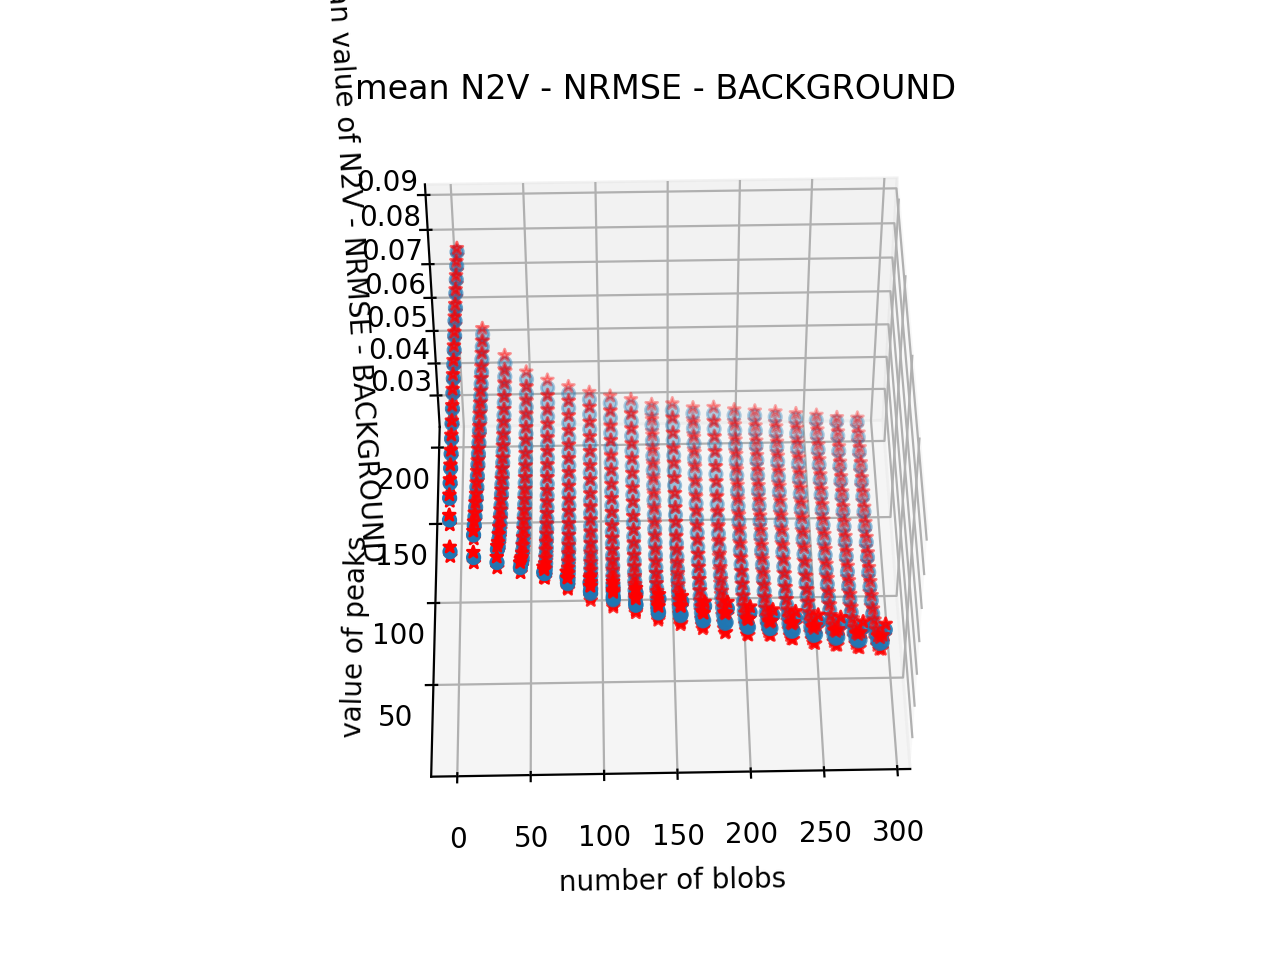

<IPython.core.display.Javascript object>


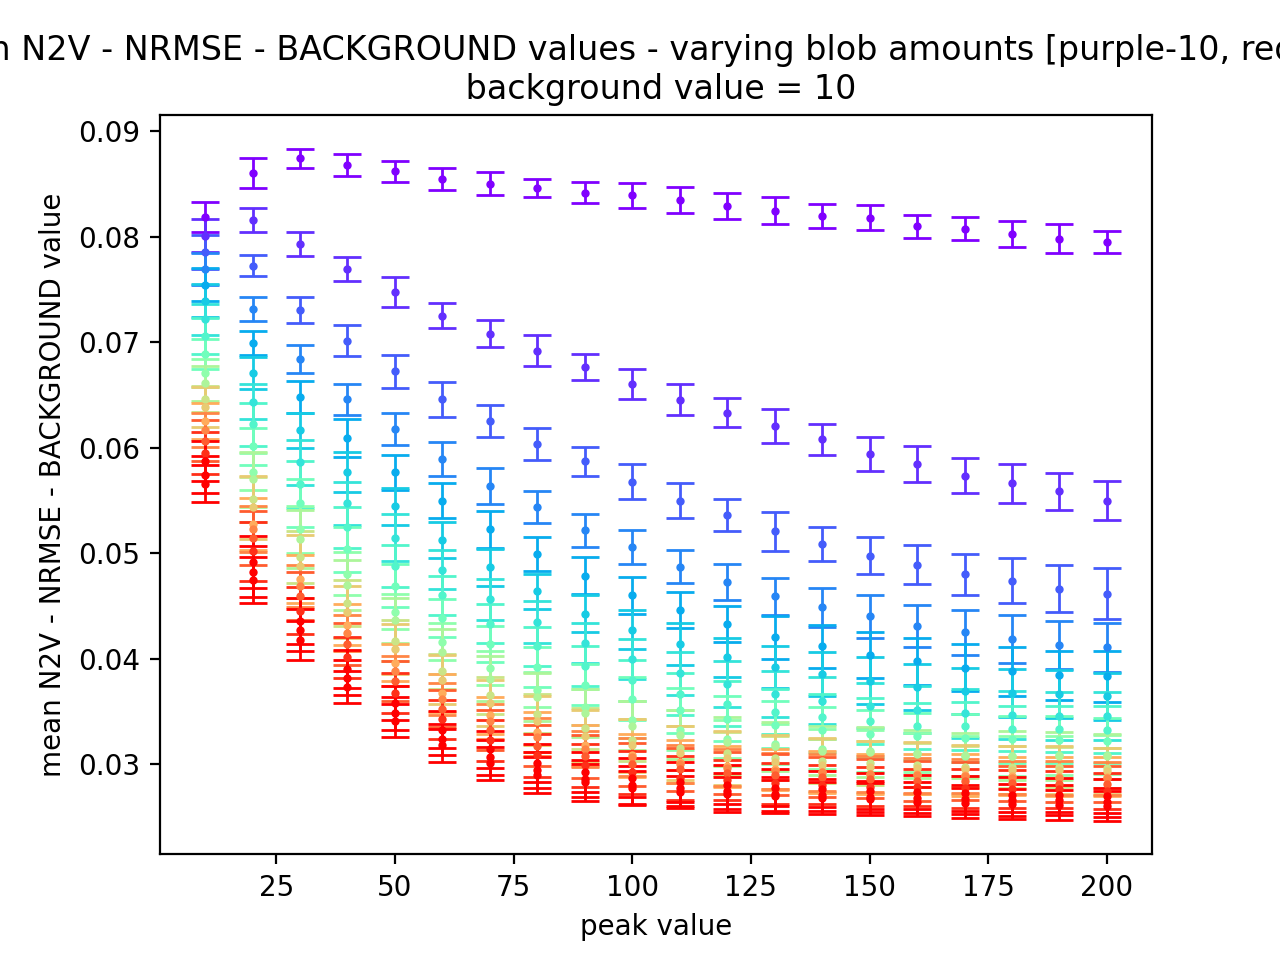

<IPython.core.display.Javascript object>


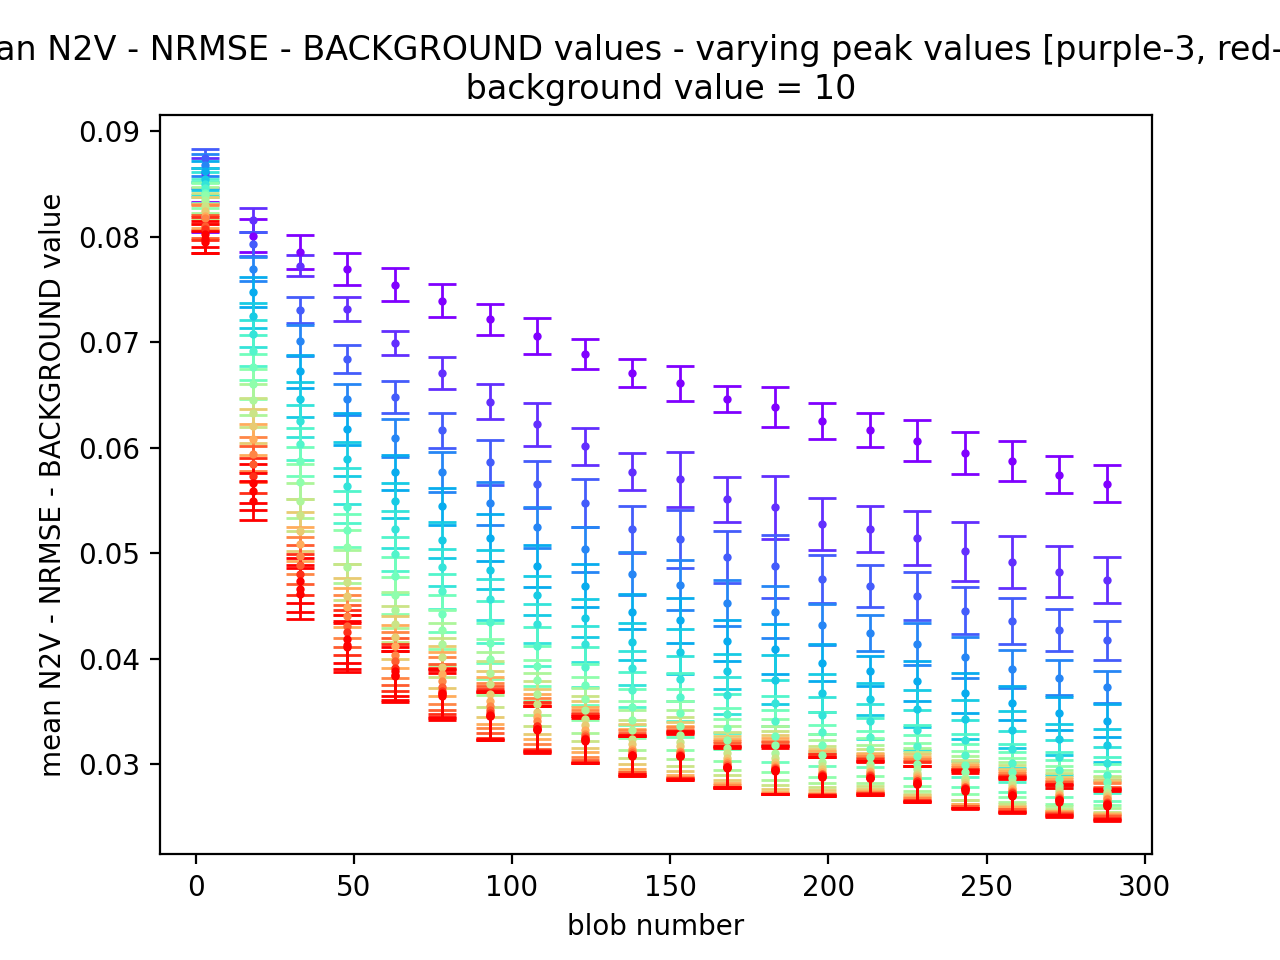

In [17]:
# N2V: -NRMSE BACKGROUND-
# 6. plotting obtained stats
stats_plot.plot_stats(metric_stats_NRMSE_N2V_background, indices_eval_zoom, 'N2V - NRMSE - BACKGROUND')